################################################################################
> # **Clone GitHub repository**
################################################################################

In [26]:

################# Clone repository from github to colab session ################

"""

run this section if you want to clone all the preTrained networks, logs, graph figures, gifs
from the GitHub repository to this colab session

"""


print("============================================================================================")

!git clone https://github.com/nikhilbarhate99/PPO-PyTorch

print("============================================================================================")



fatal: destination path 'PPO-PyTorch' already exists and is not an empty directory.


In [ ]:

"""

run this section if you want to copy all files and folders from cloned folder (PPO-PyTorch)
to current directory (/content/ or ./)

So you can load preTrained networks and log files without changing any paths

**  This will overwrite any saved networks, logs, graph figures, or gifs
    that are created in this session before copying having the same name (or number)

"""

print("============================================================================================")

!cp -rv ./PPO-PyTorch/* ./

print("============================================================================================")


In [ ]:

"""

run this section if you want to delete original cloned folder and the cloned ipynb file
(after you have copied its contents to current directory)

"""


print("============================================================================================")

# delete original cloned folder
!rm -r ./PPO-PyTorch

# delete cloned ipynb file
!rm ./PPO_colab.ipynb

print("============================================================================================")



################################################################################
> # **Install Dependencies**
################################################################################

In [54]:


############ install compatible version of OpenAI roboschool and gym ###########

!pip install swig

!pip install gymnasium[classic_control]

!pip install gymnasium[mujoco]
# !pip install roboschool==1.0.7 gym==0.15.4

# !pip install box2d-py

# !pip install Box2D

# !pip install pybullet

# !pip install gym[box2d]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.2 MB/s eta 0:00:00


################################################################################
> # **Introduction**
> The notebook is divided into 5 major parts :

*   **Part I** : define actor-critic network and PPO algorithm
*   **Part II** : train PPO algorithm and save network weights and log files
*   **Part III** : load (preTrained) network weights and test PPO algorithm
*   **Part IV** : load log files and plot graphs
*   **Part V** : install xvbf, load (preTrained) network weights and save images for gif and then generate gif

################################################################################

################################################################################
> # **Part - I**

*   define actor critic networks
*   define PPO algorithm

################################################################################

In [55]:


############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

# import
# import roboschool
import pybullet_envs


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

print("============================================================================================")




################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError


    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))






Device set to : cpu


In [ ]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   train PPO algorithm on environments
*   save preTrained networks weights and log files

################################################################################

In [ ]:

print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

# env_name = "CartPole-v1"
# has_continuous_action_space = False

env_name = "HalfCheetah-v4"
has_continuous_action_space = True

# this is for continuous action space
action_std = 1.0
action_std_decay_rate = 0.05
min_action_std = 0.1
action_std_decay_freq = int(1e6)


max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(1e5)      # save model frequency (in num timesteps)



#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps")
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:

    state,_ = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):

        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _, _= env.step(action)

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0

        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







training environment name : HalfCheetah-v4
current logging run number for HalfCheetah-v4 :  2
logging at : PPO_logs/HalfCheetah-v4//PPO_HalfCheetah-v4_log_2.csv
save checkpoint path : PPO_preTrained/HalfCheetah-v4/PPO_HalfCheetah-v4_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  400
model saving frequency : 100000 timesteps
log frequency : 800 timesteps
printing average reward over episodes in last : 1600 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  17
action space dimension :  6
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  1.0
decay rate of std of action distribution 

In [ ]:



################################ End of Part II ################################




################################################################################
> # **Part - III**

*   load and test preTrained networks on environments

################################################################################

In [60]:


print("============================================================================================")


#################################### Testing ###################################


################## hyperparameters ##################

# env_name = "CartPole-v1"
# has_continuous_action_space = False
# max_ep_len = 400
# action_std = None


env_name = "HalfCheetah-v4"
has_continuous_action_space = True
max_ep_len = 400
action_std = 0.6

# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None


# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 10    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################


env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    ep_reward = 0
    state,_ = env.reset()

    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _, _ = env.step(action)
        ep_reward += reward

        if done:
            break

    # clear buffer
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/HalfCheetah-v4/PPO_HalfCheetah-v4_0_0.pth
--------------------------------------------------------------------------------------------
Episode: 1 		 Reward: -4.79
Episode: 2 		 Reward: 80.49
Episode: 3 		 Reward: -80.02
Episode: 4 		 Reward: -14.32
Episode: 5 		 Reward: 13.0
Episode: 6 		 Reward: -92.45
Episode: 7 		 Reward: -72.02
Episode: 8 		 Reward: -79.46
Episode: 9 		 Reward: -74.58
Episode: 10 		 Reward: -61.23
average test reward : -38.54


In [61]:



################################ End of Part III ###############################




################################################################################
> # **Part - IV**

*   load log files using pandas
*   plot graph using matplotlib

################################################################################

loading data from : PPO_logs/HalfCheetah-v4//PPO_HalfCheetah-v4_log_0.csv
data shape :  (125, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/HalfCheetah-v4//PPO_HalfCheetah-v4_fig_0ECE590.png


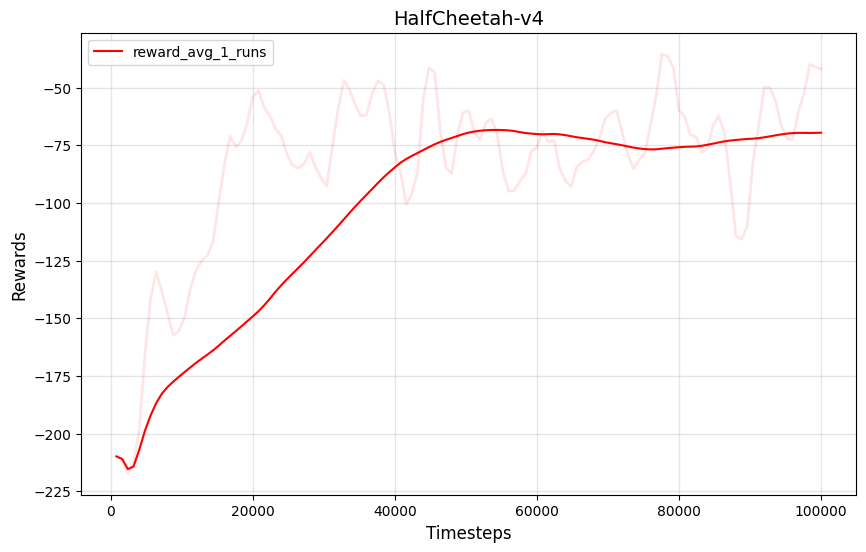

In [62]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

#env_name = 'CartPole-v1'
env_name = "HalfCheetah-v4"
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + "ECE590" + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)

    print("data shape : ", data.shape)

    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()




In [ ]:



################################ End of Part IV ################################




################################################################################
> # **Part - V**

*   install virtual display libraries for rendering on colab / remote server ^
*   load preTrained networks and save images for gif
*   generate and save gif from previously saved images

*   ^ If running locally; do not install xvbf and pyvirtualdisplay. Just comment out the virtual display code and render it normally.
*   ^ You will still require to use ipythondisplay, if you want to render it in the Jupyter Notebook.

################################################################################

In [43]:


#### to render on colab / server / headless machine install virtual display libraries

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1



In [45]:
!apt-get update && apt-get install -y xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,812 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [63]:


############################# save images for gif ##############################


import os
import glob

import gymnasium as gym
#import roboschool
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from IPython import display as ipythondisplay

from pyvirtualdisplay import Display



"""
One frame corresponding to each timestep is saved in a folder :

PPO_gif_images/env_name/000001.jpg
PPO_gif_images/env_name/000002.jpg
PPO_gif_images/env_name/000003.jpg
...
...
...


if this section is run multiple times or for multiple episodes for the same env_name;
then the saved images will be overwritten.

"""




#### beginning of virtual display code section

display = Display(visible=0, size=(400, 300))
display.start()

#### end of virtual display code section



print("============================================================================================")


################## hyperparameters ##################

# env_name = "CartPole-v1"
# has_continuous_action_space = False
# max_ep_len = 400
# action_std = None

env_name = "HalfCheetah-v4"
has_continuous_action_space = True
max_ep_len = 400
action_std = 0.6

# env_name = "LunarLander-v2"
# has_continuous_action_space = False
# max_ep_len = 300
# action_std = None

# env_name = "BipedalWalker-v2"
# has_continuous_action_space = True
# max_ep_len = 1500           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving

# env_name = "RoboschoolWalker2d-v1"
# has_continuous_action_space = True
# max_ep_len = 1000           # max timesteps in one episode
# action_std = 0.1            # set same std for action distribution which was used while saving


total_test_episodes = 1     # save gif for only one episode

render_ipython = False      # plot the images using matplotlib and ipythondisplay before saving (slow)

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003         # learning rate for actor
lr_critic = 0.001         # learning rate for critic

#####################################################


env = gym.make(env_name,render_mode="rgb_array")

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



# make directory for saving gif images
gif_images_dir = "PPO_gif_images" + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make environment directory for saving gif images
gif_images_dir = gif_images_dir + '/' + env_name + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make directory for gif
gif_dir = "PPO_gifs" + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# make environment directory for gif
gif_dir = gif_dir + '/' + env_name  + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)



ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")



test_running_reward = 0

for ep in range(1, total_test_episodes+1):

    ep_reward = 0
    state,_ = env.reset()

    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, done, _, _= env.step(action)
        ep_reward += reward

        img = env.render()


        #### beginning of ipythondisplay code section 1

        if render_ipython:
            plt.imshow(img)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

        #### end of ipythondisplay code section 1


        img = Image.fromarray(img)
        img.save(gif_images_dir + '/' + str(t).zfill(6) + '.jpg')

        if done:
            break

    # clear buffer
    ppo_agent.buffer.clear()

    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {}'.format(ep, round(ep_reward, 2)))
    ep_reward = 0



env.close()


#### beginning of ipythondisplay code section 2

if render_ipython:
    ipythondisplay.clear_output(wait=True)

#### end of ipythondisplay code section 2




print("============================================================================================")

print("total number of frames / timesteps / images saved : ", t)

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







loading network from : PPO_preTrained/HalfCheetah-v4/PPO_HalfCheetah-v4_0_0.pth
--------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Episode: 1 		 Reward: -136.66
total number of frames / timesteps / images saved :  400
average test reward : -136.66


In [64]:



######################## generate gif from saved images ########################


print("============================================================================================")

#env_name = 'CartPole-v1'
env_name = "HalfCheetah-v4"
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_num = 0     #### change this to prevent overwriting gifs in same env_name folder

# adjust following parameters to get desired duration, size (bytes) and smoothness of gif
total_timesteps = 300
step = 10
frame_duration = 150


# input images
gif_images_dir = "PPO_gif_images/" + env_name + '/*.jpg'


# ouput gif path
gif_dir = "PPO_gifs"
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_dir = gif_dir + '/' + env_name
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_path = gif_dir + '/PPO_' + env_name + '_gif_' + str(gif_num) + "ECE590"+ '.gif'



img_paths = sorted(glob.glob(gif_images_dir))
img_paths = img_paths[:total_timesteps]
img_paths = img_paths[::step]


print("total frames in gif : ", len(img_paths))
print("total duration of gif : " + str(round(len(img_paths) * frame_duration / 1000, 2)) + " seconds")



# save gif
img, *imgs = [Image.open(f) for f in img_paths]
img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, optimize=True, duration=frame_duration, loop=0)

print("saved gif at : ", gif_path)



print("============================================================================================")




total frames in gif :  30
total duration of gif : 4.5 seconds
saved gif at :  PPO_gifs/HalfCheetah-v4/PPO_HalfCheetah-v4_gif_0ECE590.gif


In [65]:

############################# check gif byte size ##############################


import os
import glob


print("============================================================================================")

# env_name = 'CartPole-v1'
env_name = "HalfCheetah-v4"
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_dir = "PPO_gifs/" + env_name + '/*.gif'

gif_paths = sorted(glob.glob(gif_dir))

for gif_path in gif_paths:
    file_size = os.path.getsize(gif_path)
    print(gif_path + '\t\t' + str(round(file_size / (1024 * 1024), 2)) + " MB")


print("============================================================================================")





PPO_gifs/HalfCheetah-v4/PPO_HalfCheetah-v4_gif_0ECE590.gif		1.41 MB


In [ ]:



################################# End of Part V ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################